# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [80]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.779768505898453

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.205192781605781

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [6]:
x = np.random.exponential(1,sample_size)
y = f(x) + np.random.uniform(-1, 1, sample_size)

In [7]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [8]:
x = x.reshape(-1,1)
linspace = linspace.reshape(-1,1)

In [9]:
tree = DecisionTreeRegressor()
tree.fit(x,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

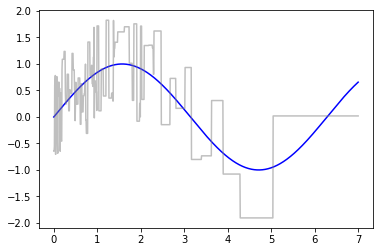

In [11]:
p = tree.predict(linspace)
plt.plot(linspace, f(linspace), 'b')
plt.plot(linspace, p, color="gray", alpha=0.5)
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").

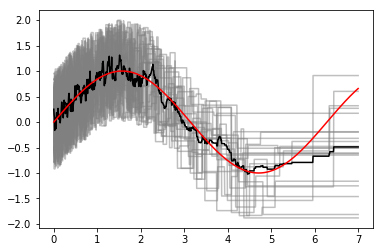

In [31]:
p = [0 for i in range(1000)]
for i in range(samples_num):
    x = np.random.exponential(1,sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    x = x.reshape(-1,1)
    q = DecisionTreeRegressor()
    q.fit(x,y)
    q = q.predict(linspace)
    p = np.add(p,q)
    plt.plot(linspace, q, color='gray', alpha=0.5)
p = [x/20 for x in p] 
    
    

plt.plot(linspace, p, color='black')
plt.plot(linspace, f(linspace), 'r')
plt.show()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

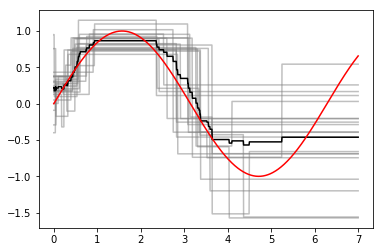

In [32]:
p = [0 for i in range(1000)]
for i in range(samples_num):
    x = np.random.exponential(1,sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    x = x.reshape(-1,1)
    q = DecisionTreeRegressor(max_depth = 2)
    q.fit(x,y)
    q = q.predict(linspace)
    p = np.add(p,q)
    plt.plot(linspace, q, color='gray', alpha=0.5)
p = [x/20 for x in p]
    
    

plt.plot(linspace, p, color='black')
plt.plot(linspace, f(linspace), 'r')
plt.show()

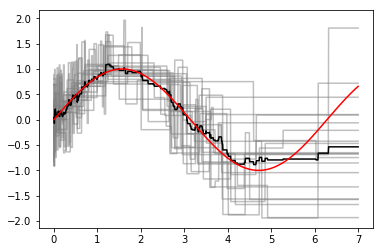

In [33]:
p = [0 for i in range(1000)]
for i in range(samples_num):
    x = np.random.exponential(1,sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    x = x.reshape(-1,1)
    q = DecisionTreeRegressor(max_depth = 4)
    q.fit(x,y)
    q = q.predict(linspace)
    p = np.add(p,q)
    plt.plot(linspace, q, color='gray', alpha=0.5)
p = [x/20 for x in p]
    
    

plt.plot(linspace, p, color='black')
plt.plot(linspace, f(linspace), 'r')
plt.show()

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Самое меньшее (но далеко не нулевое) смещение в случае без ограничений. При этом, под смещением я понимаю E(predict). Разброс, естественно (ибо переобучение), самый большой так же у доревьев без ограничения.  




__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

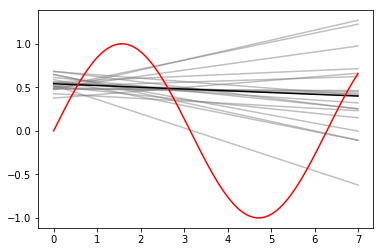

In [35]:
from sklearn.linear_model import LinearRegression

p = [0 for i in range(1000)]
for i in range(samples_num):
    x = np.random.exponential(1,sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    x = x.reshape(-1,1)
    q = LinearRegression()
    q.fit(x,y)
    q = q.predict(linspace)
    p = np.add(p,q)
    plt.plot(linspace, q, color='gray', alpha=0.5)
p = [x/20 for x in p]
    
    

plt.plot(linspace, p, color='black')
plt.plot(linspace, f(linspace), 'r')
plt.show()

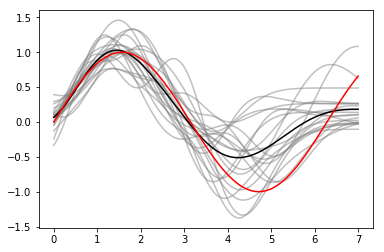

In [41]:
from sklearn import svm

p = [0 for i in range(1000)]
for i in range(samples_num):
    x = np.random.exponential(1,sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    x = x.reshape(-1,1)
    q = svm.SVR(kernel='rbf', gamma=1)
    q.fit(x,y)
    q = q.predict(linspace)
    p = np.add(p,q)
    plt.plot(linspace, q, color='gray', alpha=0.5)
p = [x/20 for x in p]
    
    

plt.plot(linspace, p, color='black')
plt.plot(linspace, f(linspace), 'r')
plt.show()

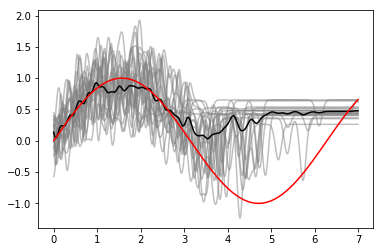

In [42]:
from sklearn import svm

p = [0 for i in range(1000)]
for i in range(samples_num):
    x = np.random.exponential(1,sample_size)
    y = f(x) + np.random.uniform(-1, 1, sample_size)
    x = x.reshape(-1,1)
    q = svm.SVR(kernel='rbf', gamma=100)
    q.fit(x,y)
    q = q.predict(linspace)
    p = np.add(p,q)
    plt.plot(linspace, q, color='gray', alpha=0.5)
p = [x/20 for x in p]
    
    

plt.plot(linspace, p, color='black')
plt.plot(linspace, f(linspace), 'r')
plt.show()

Выводы: линейные алгоритмы не подходят, ибо сколько линию не усредняй, они останется линией, в синусоиду не изогнется. А вот SVM с правильно подобранной гаммой дает весьма и весьма хорошие результаты (ибо изначально нелинеен).  

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [60]:
import pandas as pd
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score

In [106]:
#грибы на числах
data = pd.read_csv ('mashrooms.csv', header=None,names= range(23), skipinitialspace=True)
for i in data.columns.drop(22): 
 data[i] = le.fit_transform(data[i])
data[22] = le.fit_transform(data[22])
x = data.drop(0, axis =1)
y = data[0]
tree = DecisionTreeClassifier()

In [107]:
np.mean(cross_val_score(tree, x, y, cv=10,scoring=make_scorer(accuracy_score))) #грибы в числах

0.96259306612794848

In [110]:
data = pd.read_csv ('mashrooms.csv', header=None,names= range(23), skipinitialspace=True)
x = data.drop(0, axis =1)
y = data[0]

In [111]:
#грибы все категориальные
x = pd.get_dummies(x)
y = y.apply(lambda x: 1 if x=='e' else 0)
np.mean(cross_val_score(tree, x, y, cv=10,scoring=make_scorer(accuracy_score)))

0.96826568265682655

In [112]:
data = pd.read_csv ('tic-tac-toe.csv', header=None,names= range(10), skipinitialspace=True)

In [113]:
#крестикинолики в числах
for i in data.columns.drop(9): 
 data[i] = le.fit_transform(data[i])
data[9] = le.fit_transform(data[9])
x = data.drop(9, axis =1)
y = data[9]
np.mean(cross_val_score(tree, x, y, cv=10,scoring=make_scorer(accuracy_score)))

0.75621767046482191

In [114]:
#крестикинолики в категориях
data = pd.read_csv ('mashrooms.csv', header=None,names= range(10), skipinitialspace=True)
x = data.drop(9, axis =1)
y = data[9]
x = pd.get_dummies(x)
y = y.apply(lambda x: 1 if x=='positive' else 0)
np.mean(cross_val_score(tree, x, y, cv=10,scoring=make_scorer(accuracy_score)))


1.0

In [115]:
#машины на числах
data = pd.read_csv ('mashrooms.csv', header=None,names= range(7), skipinitialspace=True)
for i in data.columns.drop(6): 
    data[i] = le.fit_transform(data[i])
data[6] = le.fit_transform(data[6])
x = data.drop(6, axis =1)
y = data[6]
tree = DecisionTreeClassifier()
np.mean(cross_val_score(tree, x, y, cv=10,scoring=make_scorer(accuracy_score)))

0.49227251809689382

In [116]:
#машины на категориях
data = pd.read_csv ('mashrooms.csv', header=None,names= range(7), skipinitialspace=True)
x = data.drop(6, axis =1)
y = data[6]
x = pd.get_dummies(x)
y = y.apply(lambda x: 0 if x=='unacc' or x=='acc' else 1)
np.mean(cross_val_score(tree, x, y, cv=10,scoring=make_scorer(accuracy_score)))

1.0

In [121]:
#ясли на ячислах
data = pd.read_csv ('nursery.csv', header=None,names= range(9), skipinitialspace=True)
for i in data.columns.drop(6): 
    data[i] = le.fit_transform(data[i])
data[6] = le.fit_transform(data[6])
x = data.drop(8, axis =1)
y = data[8]
tree = DecisionTreeClassifier()
np.mean(cross_val_score(tree, x, y, cv=10,scoring=make_scorer(accuracy_score)))

/usr/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.80803753311748527

In [122]:
#ясли на категориях
data = pd.read_csv ('nursery.csv', header=None,names= range(9), skipinitialspace=True)
x = data.drop(8, axis =1)
y = data[8]
x = pd.get_dummies(x)
y = y.apply(lambda x: 0 if x=='not_recom' or x=='ecommend' else 1)
np.mean(cross_val_score(tree, x, y, cv=10,scoring=make_scorer(accuracy_score)))

1.0

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

На катигориях (коями и является большая часть данных) деревья работают определенно лучше. Это связано, во-первых с самим типом данных (приемущественно категориальные, либо те, что можно анализировать как категориальные без большой потери качества), а так же из-за характера самого алгоритма деревьев: дискретный алгаритм, следовательно удобнее работать с дискретными величинами. Плюс, создания категориальной переменной, в случае множественности категорий, приводит к созданию "новых фичей" (для алгоритма, мы то понимаем, что фичи те же самые), что очень хорошо помогает деревьям (больше выбора по какому признаку делить). 


### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [47]:
import pandas as pd

In [65]:
data = pd.read_csv('winequality-red.csv', header=0, sep = ";")

In [66]:
y = data.quality
x = data.drop('quality', 1)

In [93]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
a = cross_val_score(clf, x, y, cv=3)
(a, a.mean())

(array([ 0.45233645,  0.44277674,  0.48022599]), 0.45844639091945272)

In [94]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(n_estimators = 100)
a = cross_val_score(clf, x, y, cv=3)
(a, a.mean())

(array([ 0.51962617,  0.57410882,  0.57815443]), 0.55729647061586962)

In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(n_estimators = 100, max_features = 0.5)
a = cross_val_score(clf, x, y, cv=3)
(a, a.mean())

(array([ 0.51588785,  0.54971857,  0.5913371 ]), 0.55231450812926119)

In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)
a = cross_val_score(clf, x, y, cv=3)
(a, a.mean())

(array([ 0.51214953,  0.5684803 ,  0.60828625]), 0.56297202841731553)

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [106]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3)
y_train = train.quality
x_train = train.drop('quality', 1)
y_test = test.quality
x_test = test.drop('quality', 1)

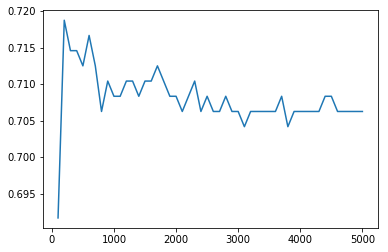

In [153]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 99, warm_start=True)
clf.fit(x_train, y_train)
for i in range(100, 5100, 100):
    clf.set_params(n_estimators = i, warm_start=True)
    clf.fit(x_train, y_train)
    acc = clf.score(x_test, y_test)
    k = int(i/100-1)
    ac[k] = acc
    
plt.plot(range(100, 5100, 100), ac)

Пик на 200 деревьях, дальше падение и очень медленный (возможно, даже статистически незначимый) спад. Исходя из характера построения (рассадки?) модели (леса), скорее всего это связано не с переобучением, а с другими эффектами. 

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [18]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras.optimizers import RMSprop

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [22]:
# Код был взят (и немного изменен) из https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py (в преамбуле задания
# говорится, что так можно при условии указания источников)

batch_size = 128
num_classes = 10
epochs = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 16s 265us/step - loss: 0.3190 - acc: 0.9094 - val_loss: 0.1795 - val_acc: 0.9441
Epoch 2/10
60000/60000 [==============================] - 13s 218us/step - loss: 0.1407 - acc: 0.9590 - val_loss: 0.1203 - val_acc: 0.9646
Epoch 3/10
60000/60000 [==============================] - 13s 222us/step - loss: 0.1001 - acc: 0.9700 - val_loss: 0.0956 - val_acc: 0.9717
Epoch 4/10
60000/60000 [==============================] - 14s 235us/step - loss: 0.0760 - acc: 0.9762 - val_loss: 0.0841 - val_acc: 0.9757
Epoch 5/10
60000/60000 [==============================] - 13s 214us/step - loss: 0.0617 - acc: 0.9812 - val_loss: 0.0980 - val_acc: 0.9714
Epoch 6/10
60000/60000 [==============================] - 13s 214us/step - loss: 0.0516 - acc: 0.9840 - val_loss: 0.0731 - val_acc: 0.9791
Epoch 7/10
60000/60000 [==============================] - 13s 222us/step - loss: 0.0420 - acc: 0.9872 - val_loss: 0.

In [ ]:
# Код был взят (и немного изменен) из https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py (в преамбуле задания
# говорится, что так можно при условии указания источников)

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(784,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [26]:
# Код был взят (и немного изменен) из https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py (в преамбуле задания
# говорится, что так можно при условии указания источников)

import keras
from keras.datasets import mnist


batch_size = 128
num_classes = 10
epochs = 10 # пощадите мой бедный целерон семилетней давности


img_rows, img_cols = 28, 28


(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255



y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



In [27]:
# Код был взят (и немного изменен) из https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py (в преамбуле задания
# говорится, что так можно при условии указания источников)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 859s 14ms/step - loss: 0.2650 - acc: 0.9202 - val_loss: 0.0676 - val_acc: 0.9796
Epoch 2/10
60000/60000 [==============================] - 889s 15ms/step - loss: 0.0584 - acc: 0.9820 - val_loss: 0.0496 - val_acc: 0.9827
Epoch 3/10
60000/60000 [==============================] - 927s 15ms/step - loss: 0.0388 - acc: 0.9884 - val_loss: 0.0416 - val_acc: 0.9869
Epoch 4/10
60000/60000 [==============================] - 940s 16ms/step - loss: 0.0281 - acc: 0.9913 - val_loss: 0.0320 - val_acc: 0.9897
Epoch 5/10
60000/60000 [==============================] - 876s 15ms/step - loss: 0.0208 - acc: 0.9936 - val_loss: 0.0352 - val_acc: 0.9893
Epoch 6/10
60000/60000 [==============================] - 933s 16ms/step - loss: 0.0151 - acc: 0.9954 - val_loss: 0.0315 - val_acc: 0.9908
Epoch 7/10
60000/60000 [==============================] - 926s 15ms/step - loss: 0.0118 - acc: 0.9965 - val_loss: 0.

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [28]:
# Код был взят (и немного изменен) из https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py (в преамбуле задания
# говорится, что так можно при условии указания источников)

import keras
from keras.datasets import mnist


batch_size = 128
num_classes = 10
epochs = 10 # пощадите мой бедный целерон семилетней давности

img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [29]:
# Код был взят (и немного изменен) из https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py (в преамбуле задания
# говорится, что так можно при условии указания источников)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 962s 16ms/step - loss: 0.3181 - acc: 0.9030 - val_loss: 0.0795 - val_acc: 0.9752
Epoch 2/10
60000/60000 [==============================] - 1003s 17ms/step - loss: 0.1094 - acc: 0.9675 - val_loss: 0.0500 - val_acc: 0.9831
Epoch 3/10
60000/60000 [==============================] - 884s 15ms/step - loss: 0.0839 - acc: 0.9752 - val_loss: 0.0434 - val_acc: 0.9855
Epoch 4/10
60000/60000 [==============================] - 944s 16ms/step - loss: 0.0701 - acc: 0.9792 - val_loss: 0.0393 - val_acc: 0.9857
Epoch 5/10
60000/60000 [==============================] - 949s 16ms/step - loss: 0.0619 - acc: 0.9824 - val_loss: 0.0339 - val_acc: 0.9887
Epoch 6/10
60000/60000 [==============================] - 947s 16ms/step - loss: 0.0562 - acc: 0.9829 - val_loss: 0.0315 - val_acc: 0.9883
Epoch 7/10
60000/60000 [==============================] - 954s 16ms/step - loss: 0.0520 - acc: 0.9847 - val_loss: 0

Добавление дроб слоев не обязано (может, но далеко не обязано) как-то улучшать обучение: ведь слои эти нужны как раз для обратного: предохранить от переобучения, с они вполне таки себе справились: во втором случае, в отличии от первого, разница между accuracy на тренировочной и тестовой выборке в пользу второй. 